In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn import tree
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


# Michele:
from preprocessing import preprocessing

# load the datasets

features = pd.read_csv('./data/dengue_features_train.csv')
labels = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [2]:
def preprocessing(features, test_features):
    
    number_train_features = features.shape[0]
    number_test_features = test_features.shape[0]

    # Merge the datasets before cleaning:
    all_features = pd.merge(features, test_features, how='outer')

    # Drop 'year, 'week_start_date' and duplicate column 'precipitation_amt_mm'
    all_features.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'year', 'week_start_date', 'precipitation_amt_mm'], axis=1, inplace=True)
   
    # One hot encoding for 'city'
    all_features = pd.merge(pd.get_dummies(all_features.city), all_features.drop('city', axis=1), left_index=True, right_index=True)

    # Defining the columns for adding the data of the past weeks:
    cols = all_features.columns.drop(['iq', 'sj', 'weekofyear'])
    
    # Adding to each observation the data of the past five weeks
    for i in range(5):
        shifted_columns = all_features[cols].shift(periods=i+1)
        shifted_columns = shifted_columns.add_suffix('_'+str(i+1))
        all_features = pd.concat([all_features, shifted_columns],axis=1)
         
        
    # Return the separated datasets
    return all_features.iloc[:number_train_features], all_features.iloc[number_train_features:]

In [3]:
X, test_features = preprocessing(features, test_features)

# Prepare y:
y = labels.loc[:,'total_cases']

# Split sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
pipeline = make_pipeline(
    KNNImputer(n_neighbors=3),
    StandardScaler(),
    ExtraTreesRegressor(n_estimators=500, criterion='squared_error'), #absolute_error
)

pipeline.fit(X_train, y_train)
pipeline.score(X_train, y_train)
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Obtain predictions and score
pred = pipeline.predict(X_test)
pred1 = pipeline.predict(X_train)
score = mean_absolute_error(y_test, pred)
print('MAE', score)

MAE 7.267527397260274


/var/folders/m1/pgl3gnds4tn0s8bm5bw7_07m0000gn/T/ipykernel_30230/1656075246.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


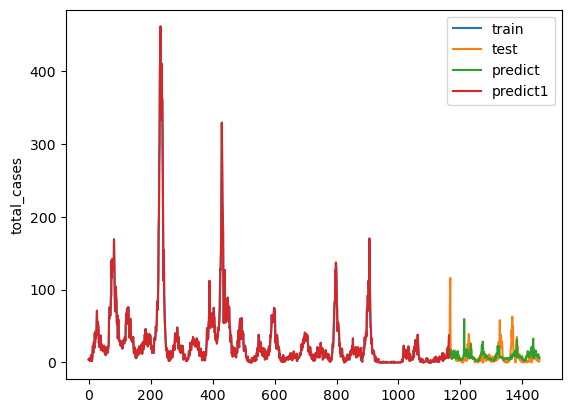

In [6]:
pred1 = pipeline.predict(X_train)
fig, ax = plt.subplots() #scatterplot
sns.lineplot(data = X_train, x=X_train.index, y=y_train, label="train")
sns.lineplot(data = X_test, x=X_test.index, y=y_test, label="test")
sns.lineplot(data = X_test, x=X_test.index, y=pred, label="predict")
sns.lineplot(data = X_train, x=X_train.index, y=pred1, label="predict1")
ax.legend()
fig.show()